# Time-explicit LCA of an electric vehicle

annotated for Dds LCA-MFA Autumn School 2025 


This notebook shows how to use `bw_timex` with a cradle-to-grave case study of an electric vehicle (ev). The case study is simplified, not meant to reflect the complexity of electric mobility but to demonstrate how to use `bw_timex`. 

> **Note:** This is the "standalone" version of this notebook with some made up background processes, but there is also a version available that works with ecoinvent and premise databases.

> **Note:** It is a slightly modified version with additional explanations compared to the [original standalone notebook](https://github.com/brightway-lca/bw_timex/blob/main/notebooks/example_electric_vehicle_standalone.ipynb)

## Prospective background databases

The `bw_timex` package itself does not provide any data - specifying prospective and dynamic information is up to the user. To make this notebook executable for anyone, anywhere, and not rely on any external data, we make up three different background databases for this example, representing the years 2020, 2030 and 2040. Also, we create a very simple biosphere database.

In [1]:
import bw2data as bd

bd.projects.set_current("electric_vehicle_standalone")

# making sure to start fresh
for db in list(bd.databases):
    del bd.databases[db]

In [2]:
biosphere = bd.Database("biosphere")
biosphere.write(
    {
        ("biosphere", "CO2"): {
            "type": "emission",
            "name": "carbon dioxide",
        },
    }
)

background_2020 = bd.Database("background_2020")
background_2030 = bd.Database("background_2030")
background_2040 = bd.Database("background_2040")

background_2020.write({})
background_2030.write({})
background_2040.write({})

background_databases = [
    background_2020,
    background_2030,
    background_2040,
]

100%|██████████| 1/1 [00:00<?, ?it/s]


Vacuuming database 


We now create some very simple processes within these databases. These process get only one aggregated CO2-emission each. The amounts of these emissions change over time.

In [3]:
process_co2_emissions = {
    "glider": (10, 5, 2.5), # for 2020, 2030 and 2040
    "powertrain": (20, 10, 7.5),
    "battery": (10, 5, 4),
    "electricity": (0.5, 0.25, 0.075),
    "glider_eol": (0.01, 0.0075, 0.005),
    "powertrain_eol": (0.01, 0.0075, 0.005),
    "battery_eol": (1, 0.5, 0.25),
}

node_co2 = biosphere.get("CO2")

for component_name, gwis in process_co2_emissions.items():
    for database, gwi in zip(background_databases, gwis):
        database.new_node(component_name, name=component_name, location="somewhere").save()
        component = database.get(component_name)
        component["reference product"] = component_name        
        component.save()
        production_amount = -1 if "eol" in component_name else 1
        component.new_edge(input=component, amount=production_amount, type="production").save()
        component.new_edge(input=node_co2, amount=gwi, type="biosphere").save()       
    

## Case study setup


In this study, we consider the following production system for our ev. Purple boxes are foreground, cyan boxes are background (i.e., ecoinvent/premise/made-up in our case).

```{mermaid}
flowchart LR
    glider_production(glider production):::ei-->ev_production
    powertrain_production(powertrain production):::ei-->ev_production
    battery_production(battery production):::ei-->ev_production
    ev_production(ev production):::fg-->driving
    electricity_generation(electricity generation):::ei-->driving
    driving(driving):::fg-->used_ev
    used_ev(used ev):::fg-->glider_eol(glider eol):::ei
    used_ev-->powertrain_eol(powertrain eol):::ei
    used_ev-->battery_eol(battery eol):::ei

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

### Modeling the production system

Now, we need to build this with brightway. If you are not interested in the modeling details, feel free to skip this section.

For our ev model we make the following assumptions:

In [4]:
ELECTRICITY_CONSUMPTION = 0.2 # kWh/km
MILEAGE = 150_000 # km
LIFETIME = 15 # years

# Overall mass: 1200 kg
MASS_GLIDER = 840 # kg
MASS_POWERTRAIN = 80 # kg
MASS_BATTERY = 280 # kg

First, we create a new foreground database:

In [5]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

Now, let's creating the foreground activities:


In [6]:
ev_production = foreground.new_node("ev_production", name="production of an electric vehicle", unit="unit")
ev_production['reference product'] = "electric vehicle"
ev_production.save()

driving = foreground.new_node("driving", name="driving an electric vehicle", unit="transport over an ev lifetime")
driving['reference product'] = "transport"
driving.save()

used_ev = foreground.new_node("used_ev", name="used electric vehicle", unit="unit")
used_ev['reference product'] = "used electric vehicle"
used_ev.save()

Now, let's build the exchanges, starting with the ev production:

In [7]:
glider_production = background_2020.get(code="glider")
powertrain_production = background_2020.get(code="powertrain")
battery_production = background_2020.get(code="battery")

ev_production.new_edge(input=ev_production, amount=1, type="production").save()

glider_to_ev = ev_production.new_edge(
    input=glider_production,
    amount=MASS_GLIDER, 
    type="technosphere"
)
powertrain_to_ev = ev_production.new_edge(
    input=powertrain_production, 
    amount=MASS_POWERTRAIN, 
    type="technosphere"
)
battery_to_ev = ev_production.new_edge(
    input=battery_production, 
    amount=MASS_BATTERY, 
    type="technosphere"
)

... the end of life:

In [8]:
glider_eol = background_2020.get(name="glider_eol")
powertrain_eol = background_2020.get(name="powertrain_eol")
battery_eol = background_2020.get(name="battery_eol")

used_ev.new_edge(input=used_ev, amount=-1, type="production").save()  # -1 as this gets rid of a used car

used_ev_to_glider_eol = used_ev.new_edge(
    input=glider_eol,
    amount=-MASS_GLIDER,
    type="technosphere",
)
used_ev_to_powertrain_eol = used_ev.new_edge(
    input=powertrain_eol,
    amount=-MASS_POWERTRAIN,
    type="technosphere",
)
used_ev_to_battery_eol = used_ev.new_edge(
    input=battery_eol,
    amount=-MASS_BATTERY,
    type="technosphere",
)

...and, finally, driving:

In [9]:
electricity_production = background_2020.get(name="electricity")

driving.new_edge(input=driving, amount=1, type="production").save()

driving_to_used_ev = driving.new_edge(input=used_ev, amount=-1, type="technosphere")
ev_to_driving = driving.new_edge(
    input=ev_production, 
    amount=1, 
    type="technosphere"
)
electricity_to_driving = driving.new_edge(
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)

### Adding temporal information

Now that the production system is modelled, we can add temporal distributions at the exchange level. The temporal information we want to embed in our product system looks somewhat like this:

```{mermaid}
flowchart LR
    glider_production(glider production):::ei-->|0-2 years prior|ev_production
    powertrain_production(powertrain production):::ei-->|1 year prior|ev_production
    battery_production(battery production):::ei-->|1 year prior|ev_production
    ev_production(ev production):::fg-->|0-3 months prior|driving
    electricity_generation(electricity generation):::ei-->|uniformly distributed<br/> over lifetime|driving
    driving(driving):::fg-->|after ev lifetime|used_ev
    used_ev(used ev):::fg-->|3 months after <br/> ev lifetime|glider_eol(glider eol):::ei
    used_ev-->|3 months after <br/> ev lifetime|powertrain_eol(powertrain eol):::ei
    used_ev-->|3 months after <br/> ev lifetime|battery_eol(battery eol):::ei

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

To include this temopral information, we use the `TemporalDistribution` class from `bw_temporalis`. For more info, take a look at the [bw_temporalis documentation](https://github.com/brightway-lca/bw_temporalis).

Notably, in addition to the timestamp of the occurence of the process (which is shown in the flowchart above), we also need to specify the amount share of the exchange that happens at that time to fully define a `TemporalDistribution`.


In [10]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

td_assembly_and_delivery = TemporalDistribution(
    date=np.array([-3, -2], dtype="timedelta64[M]"), amount=np.array([0.2, 0.8])
)

td_glider_production = TemporalDistribution(
    date=np.array([-2, -1, 0], dtype="timedelta64[Y]"), amount=np.array([0.7, 0.1, 0.2])
)

td_produce_powertrain_and_battery = TemporalDistribution(
    date=np.array([-1], dtype="timedelta64[Y]"), amount=np.array([1])
)

td_use_phase = easy_timedelta_distribution(
    start=0,
    end=LIFETIME,
    resolution="Y",
    steps=(LIFETIME + 1),
    kind="uniform", # you can also do "normal" or "triangular" distributions
)

td_disassemble_used_ev = TemporalDistribution(
    date=np.array([LIFETIME + 1], dtype="timedelta64[Y]"), amount=np.array([1])
)

td_treating_waste = TemporalDistribution(
    date=np.array([3], dtype="timedelta64[M]"), amount=np.array([1])
)

`bw_timex` "adds" (the mathematical correct term is convolution) the `Temporal_Distributions` of individual processes in the supply chain when building the timeline. We will explore this below, as it is easier to understand when looking at the final product (the timeline)

We now add the temporal information to the exchanges of our EV. We add temporal distributions to all (technosphere) exchanges, but you don't have to.


In [11]:
glider_to_ev["temporal_distribution"] = td_glider_production
glider_to_ev.save()

powertrain_to_ev["temporal_distribution"] = td_produce_powertrain_and_battery
powertrain_to_ev.save()

battery_to_ev["temporal_distribution"] = td_produce_powertrain_and_battery
battery_to_ev.save()

ev_to_driving["temporal_distribution"] = td_assembly_and_delivery
ev_to_driving.save()

electricity_to_driving["temporal_distribution"] = td_use_phase
electricity_to_driving.save()

driving_to_used_ev["temporal_distribution"] = td_disassemble_used_ev
driving_to_used_ev.save()

used_ev_to_glider_eol["temporal_distribution"] = td_treating_waste
used_ev_to_glider_eol.save()

used_ev_to_powertrain_eol["temporal_distribution"] = td_treating_waste
used_ev_to_powertrain_eol.save()

used_ev_to_battery_eol["temporal_distribution"] = td_treating_waste
used_ev_to_battery_eol.save()

### Add a characterization method

Finally, we need some characterization method. Again, this is just a simple made-up one:

In [12]:
bd.Method(("GWP", "example")).write(
    [
        (("biosphere", "CO2"), 1),
    ]
)

## LCA using `bw_timex`


#### Initialization

Now that the data is set up, we can get startet with the actual time-explicit LCA. As usual, we need to select a method first:

In [13]:
method = ("GWP", "example")

`bw_timex` needs to know the representative time of the databases:

In [14]:
from datetime import datetime

database_dates = {
    background_2020.name: datetime.strptime("2020", "%Y"),
    background_2030.name: datetime.strptime("2030", "%Y"),
    background_2040.name: datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

Now, we can instantiate a `TimexLCA`. It's structure is similar to a normal `bw2calc.LCA`, but with the additional argument `database_dates`.

Not sure about the required inputs? Check the documentation using `?`. All our classes and methods have docstrings!

In [15]:
from bw_timex import TimexLCA
TimexLCA?

Init signature: TimexLCA(demand: dict, method: tuple, database_dates: dict = None) -> None
Docstring:     
Class to perform time-explicit LCA calculations.

A TimexLCA contains the LCI of processes occurring at explicit points in time. It tracks the timing of processes,
relinks their technosphere and biosphere exchanges to match the technology landscape at that point in time,
and also keeps track of the timing of the resulting emissions. As such, it combines prospective and dynamic LCA
approaches.

TimexLCA first calculates a static LCA, which informs a priority-first graph traversal. From the
graph traversal, temporal relationships between exchanges and processes are derived. Based on
the timing of the processes, bw_timex matches the processes at the intersection between
foreground and background to the best available background databases. This temporal relinking is
achieved by using datapackages to add new time-specific processes. The new processes and their
exchanges to other techno

Let's create a `TimexLCA` object for our EV life cycle:

In [16]:
tlca = TimexLCA({driving: 1}, method, database_dates)

2025-11-10 13:30:47.497 | INFO     | bw_timex.timex_lca:__init__:114 - Initializing TimexLCA object...
2025-11-10 13:30:47.498 | INFO     | bw_timex.timex_lca:__init__:136 - Collecting node infos...


Next, we build a timeline of the exchanges. To do this, we can call the `build_timeline()` method, which does the graph traversal and creates a timeline dataframe from the results. The exchanges (rows of the dataframe) are aggregated to the resolution specified in the argument `temporal_grouping`. There are also many more options to specify the timeline creation and graph traversal process. Here are the most important ones:
- `temporal_grouping`: temporal resolution to which processes will be aggregated,"year" (default), "month", "day" or "hour"
- `interpolation_type`: How the best fitting background database is selected: "linear"(default), "closest"
- `edge_filter_function`: Custom filter function specifying when to stop the graph traversal.
- `cutoff`: stops graph traversal for nodes below this contribution to the static impact score.
- `max_calc`: stops graph traversal if this number of nodes has been traversed

For all these options, we provide sensible default values. Of course you can always just check the docstrings to see all your options and our assumptions for default values. 


#### Timeline

So, let's build the timeline. We choose a monthly temporal grouping here because we use that resolution in our temporal distributions.

In [17]:
timeline = tlca.build_timeline(starting_datetime = "2025-11-01", temporal_grouping="month")


2025-11-10 13:30:47.530 | INFO     | bw_timex.timex_lca:build_timeline:216 - No edge filter function provided. Skipping all edges in background databases.
2025-11-10 13:30:47.533 | INFO     | bw_timex.timex_lca:build_timeline:232 - Calculating base LCA...
2025-11-10 13:30:47.941 | INFO     | bw_timex.timex_lca:build_timeline:242 - Creating activity time mapping...
2025-11-10 13:30:47.944 | INFO     | bw_timex.timeline_builder:__init__:99 - Traversing supply chain graph...
2025-11-10 13:30:47.973 | INFO     | bw_timex.timeline_builder:build_timeline:142 - Building timeline...
2025-11-10 13:30:48.005 | INFO     | bw_timex.timeline_builder:get_weights_for_interpolation_between_nearest_years:528 - Reference date 2040-11-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.
2025-11-10 13:30:48.005 | INFO     | bw_timex.timeline_builder:get_weights_for_interpolation_between_nearest_years:528 - Reference date 2041-11-01 00:00:00 is higher than all prov

Starting graph traversal
Calculation count: 9


In [18]:
timeline

,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2023-08-01,glider,2025-08-01,production of an electric vehicle,588.0,"{'background_2020': 0.642, 'background_2030': ..."
1,2023-09-01,glider,2025-09-01,production of an electric vehicle,588.0,"{'background_2020': 0.633, 'background_2030': ..."
2,2024-08-01,glider,2025-08-01,production of an electric vehicle,84.0,"{'background_2020': 0.542, 'background_2030': ..."
3,2024-08-01,powertrain,2025-08-01,production of an electric vehicle,80.0,"{'background_2020': 0.542, 'background_2030': ..."
4,2024-08-01,battery,2025-08-01,production of an electric vehicle,280.0,"{'background_2020': 0.542, 'background_2030': ..."
5,2024-09-01,glider,2025-09-01,production of an electric vehicle,84.0,"{'background_2020': 0.533, 'background_2030': ..."
6,2024-09-01,powertrain,2025-09-01,production of an electric vehicle,80.0,"{'background_2020': 0.533, 'background_2030': ..."
7,2024-09-01,battery,2025-09-01,production of an electric vehicle,280.0,"{'background_2020': 0.533, 'background_2030': ..."
8,2025-08-01,glider,2025-08-01,production of an electric vehicle,168.0,"{'background_2020': 0.442, 'background_2030': ..."
9,2025-08-01,production of an electric vehicle,2025-11-01,driving an electric vehicle,0.2,None


Let's understand how `bw_timex` builds the timeline via convolution of the underlying `Temporal_Distributions`. We now zoom in on the production-related part of the timeline and compare the `Temporal_Distributions` of the inputs with the timeline results:

2025-11-01


,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
9,2025-08-01,production of an electric vehicle,2025-11-01,driving an electric vehicle,0.2,None
11,2025-09-01,production of an electric vehicle,2025-11-01,driving an electric vehicle,0.8,None


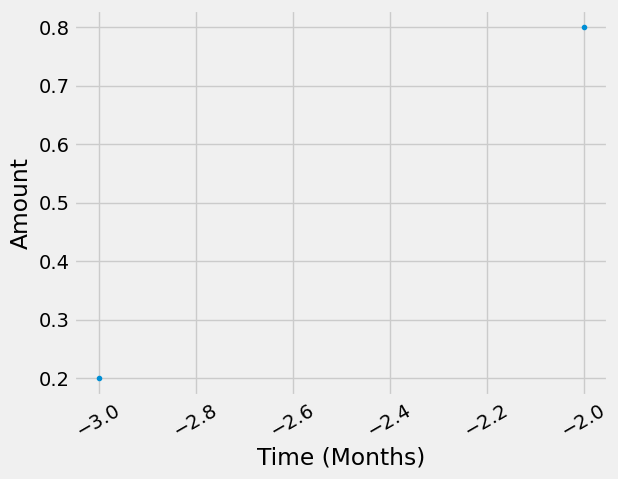

In [19]:
print(tlca.starting_datetime) # that's the starting time of the FU (driving an electric vehicle)
td_assembly_and_delivery.graph(resolution = "M")
timeline[(timeline["producer_name"] == "production of an electric vehicle")
         &(timeline["consumer_name"] == "driving an electric vehicle")]

You can see the delay between `date_consumer` and `date_producer` in the timeline is exactly what the `Temporal_Distribution` foresees. Notice also how the amount in the timeline is adjusted.

Let's check out a exchange on the second tier: glider production

,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2023-08-01,glider,2025-08-01,production of an electric vehicle,588.0,"{'background_2020': 0.642, 'background_2030': ..."
2,2024-08-01,glider,2025-08-01,production of an electric vehicle,84.0,"{'background_2020': 0.542, 'background_2030': ..."
8,2025-08-01,glider,2025-08-01,production of an electric vehicle,168.0,"{'background_2020': 0.442, 'background_2030': ..."
1,2023-09-01,glider,2025-09-01,production of an electric vehicle,588.0,"{'background_2020': 0.633, 'background_2030': ..."
5,2024-09-01,glider,2025-09-01,production of an electric vehicle,84.0,"{'background_2020': 0.533, 'background_2030': ..."
10,2025-09-01,glider,2025-09-01,production of an electric vehicle,168.0,"{'background_2020': 0.433, 'background_2030': ..."


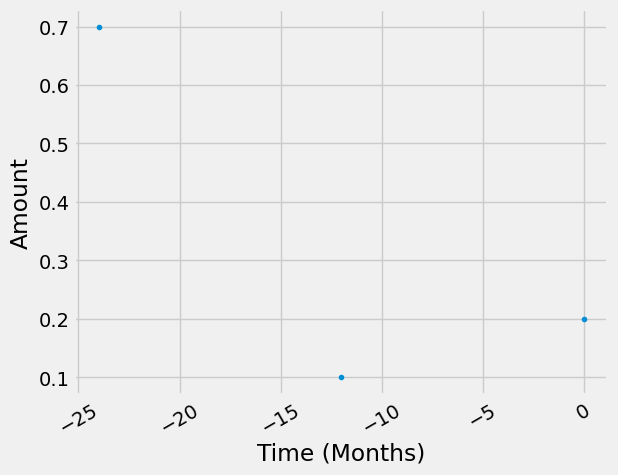

In [20]:
td_glider_production.graph(resolution = "M")
timeline[(timeline["producer_name"] == "glider")
        & (timeline["consumer_name"]=="production of an electric vehicle")].sort_values(by="date_consumer")

The `Temporal_Distributions` of the glider get "added" to each of the two temporal occurrences of EV production, which is exactly the same as a convolution:

<Axes: xlabel='Time (Months)', ylabel='Amount'>

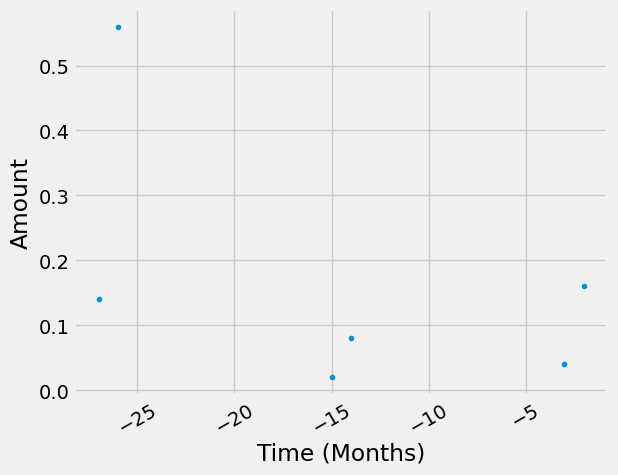

In [21]:
(td_glider_production * td_assembly_and_delivery).graph(resolution = "M")

`bw_timex` performs these convolutions for each exchange in the foreground:

```{mermaid}
flowchart LR
    glider_production(glider production):::ei-->|0-2 years prior|ev_production
    powertrain_production(powertrain production):::ei-->|1 year prior|ev_production
    battery_production(battery production):::ei-->|1 year prior|ev_production
    ev_production(ev production):::fg-->|0-3 months prior|driving
    electricity_generation(electricity generation):::ei-->|uniformly distributed<br/> over lifetime|driving
    driving(driving):::fg-->|after ev lifetime|used_ev
    used_ev(used ev):::fg-->|3 months after <br/> ev lifetime|glider_eol(glider eol):::ei
    used_ev-->|3 months after <br/> ev lifetime|powertrain_eol(powertrain eol):::ei
    used_ev-->|3 months after <br/> ev lifetime|battery_eol(battery eol):::ei

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```


The timeline then shows us the temporal sequence. 


In [22]:
timeline

,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2023-08-01,glider,2025-08-01,production of an electric vehicle,588.0,"{'background_2020': 0.642, 'background_2030': ..."
1,2023-09-01,glider,2025-09-01,production of an electric vehicle,588.0,"{'background_2020': 0.633, 'background_2030': ..."
2,2024-08-01,glider,2025-08-01,production of an electric vehicle,84.0,"{'background_2020': 0.542, 'background_2030': ..."
3,2024-08-01,powertrain,2025-08-01,production of an electric vehicle,80.0,"{'background_2020': 0.542, 'background_2030': ..."
4,2024-08-01,battery,2025-08-01,production of an electric vehicle,280.0,"{'background_2020': 0.542, 'background_2030': ..."
5,2024-09-01,glider,2025-09-01,production of an electric vehicle,84.0,"{'background_2020': 0.533, 'background_2030': ..."
6,2024-09-01,powertrain,2025-09-01,production of an electric vehicle,80.0,"{'background_2020': 0.533, 'background_2030': ..."
7,2024-09-01,battery,2025-09-01,production of an electric vehicle,280.0,"{'background_2020': 0.533, 'background_2030': ..."
8,2025-08-01,glider,2025-08-01,production of an electric vehicle,168.0,"{'background_2020': 0.442, 'background_2030': ..."
9,2025-08-01,production of an electric vehicle,2025-11-01,driving an electric vehicle,0.2,None


**Note**: the amounts in the timeline relate to what is produced if the original reference product amount was consumed, corresponding to the A-matrix elements. This still needs to be multiplied with the actual supply (LCA maths), to get the actual amount consumed at that time step.

**Note**: The interpolation weights in the timeline (right most column above) specify the share of the amount of an exchange to be sourced from the respective database. 
`None` means that the exchange is in the foreground supply chain, and not at the intersection with the background system.  

### LCI

Next, we calculate the time-explicit LCI. The `TimexLCA.lci()` function takes care of all the relinking, based on the information from the timeline. 

In [23]:
tlca.lci()

2025-11-10 13:30:48.784 | INFO     | bw_timex.timex_lca:lci:360 - Expanding matrices...
2025-11-10 13:30:48.861 | INFO     | bw_timex.timex_lca:lci:379 - Calculating dynamic inventory...


Taking a look at the `dynamic_inventory` that was now created, we can see that it has more rows (emissions) one - even though co2 is the only biosphere flow we modeled. Instead of one row for each emission in the biosphere database we now get one row for each emission at each point in time.

In [24]:
tlca.dynamic_inventory #rows, #cols

<23x57 sparse matrix of type '<class 'numpy.float64'>'
	with 29 stored elements in Compressed Sparse Row format>

The standard, non-dynamic inventory has far less rows because the temporal resolution is missing. Looking at the timeline again, we see that we have processes at 23 different points in time (only counting the ones that actually directly produce emissions), which exactly matches the ratio of the dimensions of our two inventories:

In [25]:
tlca.base_lca.inventory.shape # (#rows, #cols)

(1, 24)

In [26]:
tlca.dynamic_inventory.shape[0]/tlca.base_lca.inventory.shape[0]

23.0

While under the hood, the dynamic inventory is calculated as a sparse matrix, there is also a more human-friendly version as a pandas DataFrame:

In [27]:
tlca.dynamic_inventory_df

,date,amount,flow,activity
0,2023-08-01,965.496000,1,26
1,2023-09-01,3840.816000,1,27
2,2024-08-01,431.760000,1,30
3,2024-08-01,246.720000,1,29
4,2024-08-01,129.528000,1,28
5,2024-09-01,1716.960000,1,33
6,2024-09-01,981.120000,1,32
7,2024-09-01,515.088000,1,31
8,2025-08-01,242.256000,1,34
9,2025-09-01,962.976000,1,36


We could make it even more human-friendly by replacing the ids with the names of the biosphere and technosphere flows

In [28]:
bio_name_mapping = {
    flow: bd.get_node(id = flow).get("name")
    for flow in tlca.dynamic_inventory_df["flow"].unique()
}   
tlca.dynamic_inventory_df["flow_name"] = tlca.dynamic_inventory_df["flow"].map(bio_name_mapping)

activity_name_mapping = {
    activity: tlca.get_activity_name_from_time_mapped_id(activity)
    for activity in tlca.dynamic_inventory_df["activity"].unique()
}
tlca.dynamic_inventory_df["activity_name"] = tlca.dynamic_inventory_df["activity"].map(activity_name_mapping)

tlca.dynamic_inventory_df

,date,amount,flow,activity,flow_name,activity_name
0,2023-08-01,965.496000,1,26,carbon dioxide,glider
1,2023-09-01,3840.816000,1,27,carbon dioxide,glider
2,2024-08-01,431.760000,1,30,carbon dioxide,battery
3,2024-08-01,246.720000,1,29,carbon dioxide,powertrain
4,2024-08-01,129.528000,1,28,carbon dioxide,glider
5,2024-09-01,1716.960000,1,33,carbon dioxide,battery
6,2024-09-01,981.120000,1,32,carbon dioxide,powertrain
7,2024-09-01,515.088000,1,31,carbon dioxide,glider
8,2025-08-01,242.256000,1,34,carbon dioxide,glider
9,2025-09-01,962.976000,1,36,carbon dioxide,glider


If we are only interested in the new overall time-explicit scores and don't care about the timing of the emissions, we can set `build_dynamic_biosphere=False` (default is `True`), which saves time and memory. In that case, you only get the `TimexLCA.lca.inventory`, but not the `TimexLCA.dynamic_inventory`.

LCIA

In case the timing of emissions is not important, one can directly calculate the LCIA the "standard way" using static characterization methods. Per default, the following calculates the static lcia score based on the impact method chosen in the very beginning:

In [29]:
tlca.static_lcia()
tlca.static_score   #kg CO2-eq

16038.882535268815

At this point, we can already compare these time-explicit results to the results of an "ordinary", completely static LCA. These already exist within the TimexLCA class, originally to set the priorities for the graph traversal:

In [30]:
tlca.base_lca.score

28089.199999794364

## Dynamic Characterization
In addition to the standard static characterization, the time-explicit, dynamic inventory generated by a `TimexLCA` allows for dynamic characterization. 


This is out of scope of the this 1-hour workshop, but you can check out the following resources on dynamic characterization in your own time:
- at the bottom of [original EV notebook](https://github.com/brightway-lca/bw_timex/blob/main/notebooks/example_electric_vehicle_standalone.ipynb),  
- a separate, [simple example on dynamic characterization](https://github.com/TimoDiepers/timex/blob/main/notebooks/example_simple_dynamic_characterization.ipynb) 
- or the separate (but fully compatible) package [dynamic_characterization](https://dynamic-characterization.readthedocs.io/en/latest/). 



